In [1]:
#!/usr/bin/python
'''
Evaluate how well solutions match when run multiple times, with varying sample size
'''
import sys
import os
import fnmatch
import numpy as np
from metient.util.vertex_labeling_util import LabeledTree
from metient.util.globals import *
from metient.util import eval_util as eutil

import re
import pickle

REPO_DIR = os.path.join(os.getcwd(), "../")

DATE = "12122023"
PARAMS = "calibrate_wip_gen0.2_parseps1calandeval"
# plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
pc_map = {'mS':0, 'pS': 1, 'mM': 2, 'pM': 3, 'mR': 4, 'pR': 5}

from statannot import add_stat_annotation


CUDA GPU: False


<Figure size 640x480 with 0 Axes>

In [2]:
import gzip

def get_num_mut_trees(mut_tree_fn):
    with open(mut_tree_fn, 'r') as f:
        # look for line w/ "3 #trees" as an example
        for line in f:
            if  "#trees" in line:
                return int(line.strip().split()[0])    

def get_pckl_info(bs, run, site, mig_type, seed, tree_num, topk):
    prediction_dir = os.path.join(REPO_DIR, 'test', 'machina_simulated_data', f'sample_size_experiments_{PARAMS}_{DATE}/predictions_batch_exp_bs{bs}_{PARAMS}_r{run}_{DATE}')
    predicted_site_mig_type_data_dir = os.path.join(prediction_dir, site, mig_type)
    
    with gzip.open(os.path.join(predicted_site_mig_type_data_dir, f"tree{tree_num}_seed{seed}_evaluate.pkl.gz"), "rb") as f:
        pckl = pickle.load(f)
    Vs = pckl[OUT_LABElING_KEY]
    k = topk if len(Vs) >= topk else len(Vs)
    Vs = Vs[:k]
    As = pckl[OUT_ADJ_KEY][:k]
    losses = pckl[OUT_LOSSES_KEY][:k]
    return Vs, As, losses

def get_rank_to_percent_runs(solution_to_losses, run_num_to_solutions):
       
    # get the avg loss across runs for each solution
    for solution in solution_to_losses:
        solution_to_losses[solution] = sum(solution_to_losses[solution])/len(solution_to_losses[solution])
    solution_losses_list = [(k,v) for k,v in solution_to_losses.items()]
    solution_losses_list = sorted(solution_losses_list, key=lambda x: x[1])

    rank_to_percent_runs = {}
    # What % of runs get the solution as a function of the rank on the joined list?
    for rank, (soln,_) in enumerate(solution_losses_list):
        rank_to_percent_runs[rank] = []
        for run in run_num_to_solutions:
            if soln in run_num_to_solutions[run]:
                rank_to_percent_runs[rank].append(run)
    rank_to_percent_runs = {rank:(len(rank_to_percent_runs[rank])/num_runs) for rank in rank_to_percent_runs}
    return rank_to_percent_runs

In [5]:
from tqdm import tqdm
import torch

topk = 5 # how many of the top solutions to check for 
num_runs = 5

sites = ["m8", "m5"]
mig_types = ["M", "mS", "R", "S"]
batch_sizes = [64, 256, 1024]

print(f"matching top {topk} solutions")

m5_bs_to_rank_to_percentages = {}
m8_bs_to_rank_to_percentages = {}
all_sites_bs_to_rank_to_percentages = {}

sims_dir = os.path.join(REPO_DIR, "data/machina_sims")

for bs in batch_sizes:
    print("batch size:", bs)
    m5_bs_to_rank_to_percentages[bs] = {}
    m8_bs_to_rank_to_percentages[bs] = {}
    all_sites_bs_to_rank_to_percentages[bs] = {}
    for site in sites:
        for mig_type in mig_types:
            # Get all seeds for mig_type + site combo
            site_mig_type_dir = os.path.join(sims_dir, site, mig_type)
            seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
            seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
            print(site, mig_type)
            for seed in tqdm(seeds):
                # Get all the clone trees for this seed
                num_trees = get_num_mut_trees(os.path.join(sims_dir, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt"))
                for tree_num in range(num_trees):
                    # across all the runs for this mig_type + site + seed + clone tree combo, 
                    # get the union of all solutions
                    solution_to_losses = {}
                    run_num_to_solutions = {}
                    for run in range(1,num_runs+1):
                        Vs, As, losses = get_pckl_info(bs, run, site, mig_type, seed, tree_num, topk)
                        run_num_to_solutions[run] = []
                        for V,A,loss in zip(Vs, As, losses):
                            V = torch.tensor(V)
                            A = torch.tensor(A)
                            tree = LabeledTree(A, V)
                            if tree not in solution_to_losses:
                                solution_to_losses[tree] = []
                            solution_to_losses[tree].append(loss)
                            run_num_to_solutions[run].append(tree)
                    rank_to_percent_runs = get_rank_to_percent_runs(solution_to_losses, run_num_to_solutions)
                    #print(rank_to_percent_runs)
                    bs_to_rank_to_percentages = m5_bs_to_rank_to_percentages if site == "m5" else m8_bs_to_rank_to_percentages
                    for rank in rank_to_percent_runs:
                        if rank not in bs_to_rank_to_percentages[bs]:
                            bs_to_rank_to_percentages[bs][rank] = []
                            all_sites_bs_to_rank_to_percentages[bs][rank] = []
                        bs_to_rank_to_percentages[bs][rank].append(rank_to_percent_runs[rank])
                        all_sites_bs_to_rank_to_percentages[bs][rank].append(rank_to_percent_runs[rank])



 10%|█         | 1/10 [00:00<00:01,  5.73it/s]

matching top 5 solutions
batch size: 64
m8 M


  0%|          | 0/10 [00:00<?, ?it/s]

m8 mS


  0%|          | 0/10 [00:00<?, ?it/s]

m8 R


  0%|          | 0/10 [00:00<?, ?it/s]

m8 S


  0%|          | 0/10 [00:00<?, ?it/s]

m5 M


  0%|          | 0/10 [00:00<?, ?it/s]

m5 mS


  0%|          | 0/10 [00:00<?, ?it/s]

m5 R


 10%|█         | 1/10 [00:00<00:01,  7.68it/s]

m5 S


  0%|          | 0/10 [00:00<?, ?it/s]

batch size: 256
m8 M


  0%|          | 0/10 [00:00<?, ?it/s]

m8 mS


  0%|          | 0/10 [00:00<?, ?it/s]

m8 R


  0%|          | 0/10 [00:00<?, ?it/s]

m8 S


  0%|          | 0/10 [00:00<?, ?it/s]

m5 M


 10%|█         | 1/10 [00:00<00:01,  5.20it/s]

m5 mS


  0%|          | 0/10 [00:00<?, ?it/s]

m5 R


  0%|          | 0/10 [00:00<?, ?it/s]

m5 S


  0%|          | 0/10 [00:00<?, ?it/s]

batch size: 1024
m8 M


  0%|          | 0/10 [00:00<?, ?it/s]

m8 mS


  0%|          | 0/10 [00:00<?, ?it/s]

m8 R


  0%|          | 0/10 [00:00<?, ?it/s]

m8 S


  0%|          | 0/10 [00:00<?, ?it/s]

m5 M


  0%|          | 0/10 [00:00<?, ?it/s]

m5 mS


  0%|          | 0/10 [00:00<?, ?it/s]

m5 R


  0%|          | 0/10 [00:00<?, ?it/s]

m5 S


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


In [6]:
import pandas as pd

m8_data = []
for bs in m8_bs_to_rank_to_percentages:
    for rank in m8_bs_to_rank_to_percentages[bs]:
        avg = 100*(sum(m8_bs_to_rank_to_percentages[bs][rank])/len(m8_bs_to_rank_to_percentages[bs][rank]))
        m8_data.append([rank+1, f"Metient-{bs}", avg])
m8_df = pd.DataFrame(m8_data, columns=["Rank", "Method", "% runs"])
m8_df

,Rank,Method,% runs
0,1,Metient-64,99.152
1,2,Metient-64,99.340
2,3,Metient-64,98.961
3,4,Metient-64,98.631
4,5,Metient-64,98.284
5,6,Metient-64,40.000
6,7,Metient-64,40.000
7,8,Metient-64,34.000
8,9,Metient-64,26.667
9,10,Metient-64,32.500


In [7]:
m5_data = []
for bs in m5_bs_to_rank_to_percentages:
    for rank in m5_bs_to_rank_to_percentages[bs]:
        avg = 100*(sum(m5_bs_to_rank_to_percentages[bs][rank])/len(m5_bs_to_rank_to_percentages[bs][rank]))
        m5_data.append([rank+1, f"Metient-{bs}", avg])
m5_df = pd.DataFrame(m5_data, columns=["Rank", "Method", "% runs"])
m5_df

,Rank,Method,% runs
0,1,Metient-64,98.976
1,2,Metient-64,98.838
2,3,Metient-64,98.432
3,4,Metient-64,98.271
4,5,Metient-64,97.407
5,6,Metient-64,61.111
6,7,Metient-64,44.444
7,8,Metient-64,40.000
8,9,Metient-64,40.000
9,10,Metient-64,36.000


In [8]:
all_sites_data = []
for bs in all_sites_bs_to_rank_to_percentages:
    for rank in all_sites_bs_to_rank_to_percentages[bs]:
        avg = 100*(sum(all_sites_bs_to_rank_to_percentages[bs][rank])/len(all_sites_bs_to_rank_to_percentages[bs][rank]))
        all_sites_data.append([rank+1, f"Metient-{bs}", avg])
all_sites_df = pd.DataFrame(all_sites_data, columns=["Rank", "Method", "% runs"])
all_sites_df

,Rank,Method,% runs
0,1,Metient-64,98.976
1,2,Metient-64,98.838
2,3,Metient-64,98.432
3,4,Metient-64,98.271
4,5,Metient-64,97.407
5,6,Metient-64,61.111
6,7,Metient-64,44.444
7,8,Metient-64,40.000
8,9,Metient-64,40.000
9,10,Metient-64,36.000


[(0.48942421, 0.72854938, 0.56751036), (0.34892097, 0.64828676, 0.56513633), (0.24929311, 0.56486397, 0.5586654)]


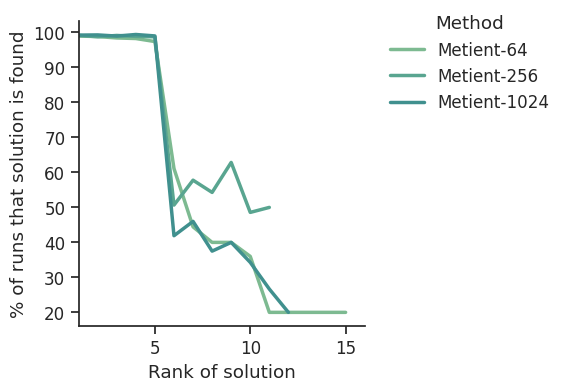

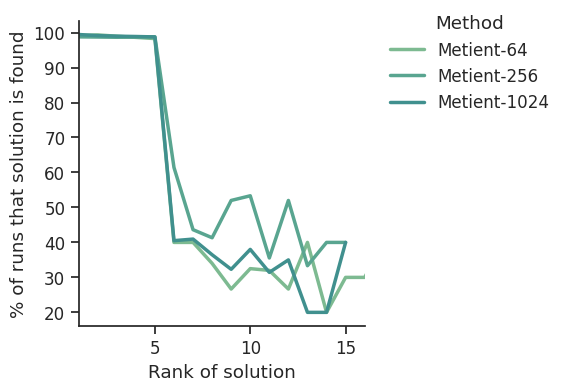

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("crest")
colors = colors[:len(batch_sizes)]
print(colors)
sns.set_palette(sns.color_palette(colors))

for name,df in zip(["m5", "m8"], [m5_df, m8_df]):
    with sns.plotting_context("notebook", font_scale=1.1):
        g = sns.relplot(
            data=df, x="Rank", y="% runs",
            height=4, aspect=1.0, dashes=False, linewidth=2.5,
            hue="Method", style="Method", kind="line", errorbar='sd', legend=True,
        )

        (g.set_axis_labels("Rank of solution", "% of runs that solution is found")
          .set_titles("boop")
          .tight_layout(w_pad=0))
        plt.xlim(1,16)
        sns.move_legend(g, "upper right")
        plt.show()
        

        fig = g.fig
        #out_name = ("_").join(y_labels[i].split(" ") + x.split(" "))
        fig.savefig(os.path.join(REPO_DIR, "test/output_plots", f"{name}_percent_solns_found_{PARAMS}_{DATE}.png"), dpi=600) 


[(0.48942421, 0.72854938, 0.56751036), (0.34892097, 0.64828676, 0.56513633), (0.24929311, 0.56486397, 0.5586654)]


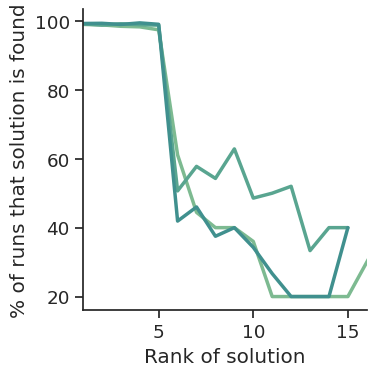

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("crest")
colors = colors[:len(batch_sizes)]
print(colors)
sns.set_palette(sns.color_palette(colors))

with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.relplot(
        data=all_sites_df, x="Rank", y="% runs",
        height=4, aspect=1.0, dashes=False, linewidth=2.5,
        hue="Method", style="Method", kind="line", errorbar='sd', legend=False,
    )

    (g.set_axis_labels("Rank of solution", "% of runs that solution is found")
      .set_titles("boop")
      .tight_layout(w_pad=0))
    plt.xlim(1,16)
    plt.show()


    fig = g.fig
    fig.savefig(os.path.join(REPO_DIR, "test/output_plots", f"all_sites_percent_solns_found_{PARAMS}_{DATE}.png"), dpi=600) 
